# Import libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

# Import data

In [2]:
df = pd.read_csv('risk_factors (2).csv', index_col= 0)
df.head()

,PARA_A,PARA_B,TOTAL,Sector_score,numbers,LOSS_SCORE,Money_Value,History_score,District,Risk
0,4.18,2.50,6.68,3.89,5.0,2,3.38,2,2,1
1,0.00,4.83,4.83,3.89,5.0,2,0.94,2,2,0
2,0.51,0.23,0.74,3.89,5.0,2,0.00,2,2,0
3,0.00,10.80,10.80,3.89,6.0,2,11.75,2,2,1
4,0.00,0.08,0.08,3.89,5.0,2,0.00,2,2,0


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776 entries, 0 to 775
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PARA_A         776 non-null    float64
 1   PARA_B         776 non-null    float64
 2   TOTAL          776 non-null    float64
 3   Sector_score   776 non-null    float64
 4   numbers        776 non-null    float64
 5   LOSS_SCORE     776 non-null    int64  
 6   Money_Value    775 non-null    float64
 7   History_score  776 non-null    int64  
 8   District       776 non-null    int64  
 9   Risk           776 non-null    int64  
dtypes: float64(6), int64(4)
memory usage: 66.7 KB


- Conveniently all the attributes 
- There is 1 missing value in 'Money_Value' column

In [4]:
df.Money_Value.fillna(value = df.Money_Value.median(), inplace=True)

C:\Users\Kirthana\AppData\Local\Temp\ipykernel_13280\2923721953.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Money_Value.fillna(value = df.Money_Value.median(), inplace=True)


C:\Users\Kirthana\AppData\Local\Temp\ipykernel_13280\1919229409.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(df.Risk, edgecolor = 'black', palette = [ '#00C851','#ff4444'])
C:\Users\Kirthana\AppData\Local\Temp\ipykernel_13280\1919229409.py:1: UserWarning: 
The palette list has fewer values (2) than needed (776) and will cycle, which may produce an uninterpretable plot.
  plot = sns.countplot(df.Risk, edgecolor = 'black', palette = [ '#00C851','#ff4444'])


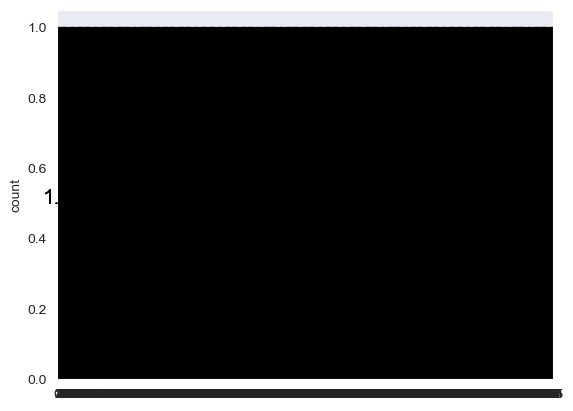

Percentage difference = 0.0%


In [5]:
plot = sns.countplot(df.Risk, edgecolor = 'black', palette = [ '#00C851','#ff4444'])

bars = plot.patches

plot.annotate(bars[0].get_height(), (0, bars[0].get_height()/2),
              ha = 'center', fontsize = 15, color = 'black')

plot.annotate(bars[1].get_height(), (1, bars[1].get_height()/2),
              ha = 'center', fontsize = 15, color = 'black')

plt.show()

percentage_diff = round(100*(bars[0].get_height() - bars[1].get_height())/((bars[0].get_height() + bars[1].get_height())/2),1)

print(f'Percentage difference = {percentage_diff}%')

- That is some amount of class imbalance in the data. To put a number on it, we have calculated percentage difference(which is just one way of looking at it)
- There are no absolute values to state if the imbalance is high or very high or low etc
- In this case, the imbalance is not very serious

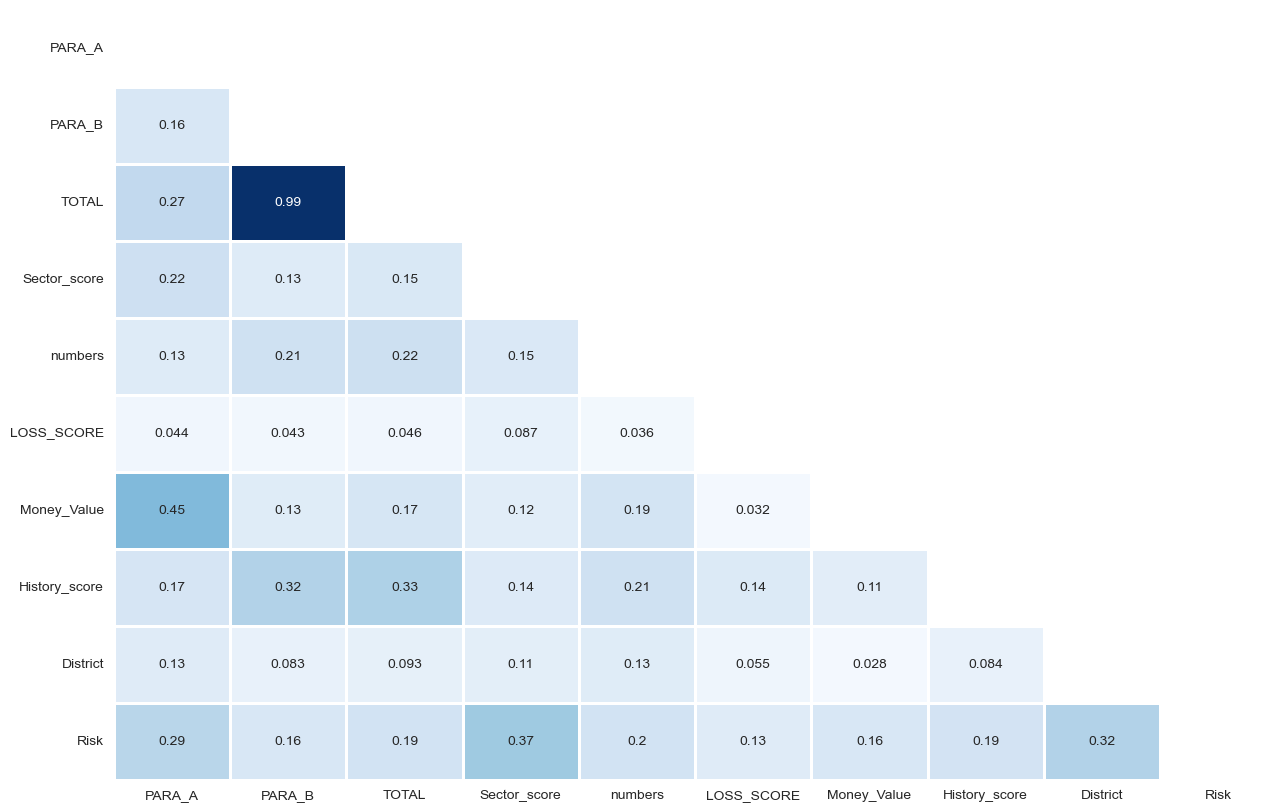

In [6]:
def correlation_plot(df):
    
    corr = abs(df.corr()) # correlation matrix
    lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
    mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

    plt.figure(figsize = (15,10))  # setting the figure size
    sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
    sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', xticklabels = corr.index,
                yticklabels = corr.columns,cbar = False, annot= True, linewidths= 1, mask = mask)   # Da Heatmap
    plt.show()
    
correlation_plot(df)

- 'TOTAL' and 'PARA_B' have almost a 100% correlation
- Let's drop 'TOTAL' 

In [7]:
df.drop(columns='TOTAL', inplace=True)

# Data prep

In [8]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 1)

In [9]:
X_train.columns

Index(['PARA_A', 'PARA_B', 'Sector_score', 'numbers', 'LOSS_SCORE',
       'Money_Value', 'History_score', 'District'],
      dtype='object')

In [10]:
y_train.name

'Risk'

# Train and Evaluate

In [11]:
def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, and data as inputs
    from sklearn import metrics
    from sklearn.model_selection import cross_val_score
    
    model.fit(X_train, y_train)   # fir the model with the train data

    pred = model.predict(X_test)  # make predictions on the test set

    score = round(model.score(X_test, y_test), 3)   # compute accuracy score for test set


    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()  # compute the confusion matrix from the predictions and actuals

    recall = round(tp/(tp+fn), 3)   
    precision = round(tp/(tp+fp), 3)  
    specificity =round(tn/(tn+fp),3) 
    f1_score =  round(2*precision*recall/(precision + recall), 3)
    
   
    return score, recall, precision, specificity, f1_score  # return all the metrics

In [12]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)

metrics = fit_n_print(dt, X_train, X_test, y_train, y_test)

In [13]:
result = pd.DataFrame(columns = ['score', 'recall', 'precision', 'specificity', 'f1_score'])

result.loc['Decision Tree'] = metrics

In [14]:
result

,score,recall,precision,specificity,f1_score
Decision Tree,0.995,0.992,1.0,1.0,0.996


- Some of the scores are 100%
- Let's check out the feature importances using the trained decision tree model

In [16]:
feature_importances = pd.DataFrame({'features': X_train.columns, 'Importance': dt.feature_importances_})
feature_importances

,features,Importance
0,PARA_A,0.549965
1,PARA_B,0.173436
2,Sector_score,0.015055
3,numbers,0.014001
4,LOSS_SCORE,0.014263
5,Money_Value,0.047043
6,History_score,0.000000
7,District,0.186238


- What would be the performance if we were to train the models by picking out features based on the above "importances" ?

In [17]:
most_important = list(feature_importances[feature_importances.Importance > 0.1].features)
most_important

['PARA_A', 'PARA_B', 'District']

In [18]:
X = df.loc[:,most_important]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 1)

result.loc['Decision Tree with important variables'] = fit_n_print(dt, X_train, X_test, y_train, y_test)

# Result

In [19]:
result

,score,recall,precision,specificity,f1_score
Decision Tree,0.995,0.992,1.000,1.000,0.996
Decision Tree with important variables,0.948,0.943,0.975,0.958,0.959
